# Lab 3.0: More Hypothesis Testing
## Type II Error and Power
What is the type II error and power for your test on the mean from Lab 2.0, assuming that both the true means have increased by 30% and the pooled standard deviation has increased by a factor of 1.1?

That is, assume that the true mean is 1.3 times the early mean, and that the true pooled standard deviation is 1.1 times sigma prime (our test estimate of pooled estimator for the two observed data sets).

In [1]:
# Import modules

import xlrd
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import statistics as stats
import numpy as np
from scipy.interpolate import interp1d

In [2]:
# Read the excel file
Skykomish_data_file = 'Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'
Skykomish_data = pd.read_excel(Skykomish_data_file)

# Preview our data
Skykomish_data

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08
3,1932-02-26,1932,83300,20.70
4,1932-11-13,1933,72500,19.50
...,...,...,...,...
76,2005-01-18,2005,74600,19.55
77,2005-12-24,2006,33800,14.27
78,2006-11-06,2007,129000,24.51
79,2007-12-03,2008,51100,16.79


In [3]:
# Divide the data into the early period (before and including 1975) and late period (after 1975). 
# And select only the 'peak value (cfs)' column for each time period

early = Skykomish_data['peak value (cfs)'][ Skykomish_data['water year'] <= 1975 ] 
late = Skykomish_data['peak value (cfs)'][ Skykomish_data['water year'] > 1975 ] 

In [4]:
# Calculate type II error and power

n = len(early)
m = len(late)

conf = .95

z_alpha = st.norm.ppf(conf)

mean1 = stats.mean(early)
mean2 = stats.mean(late)

sd1 = stats.stdev(early)
sd2 = stats.stdev(late)

pooled_sd = math.sqrt(sd1**2/n + sd2**2/m)

delta_star = .3 * mean1

sigma_star = 1.1 * pooled_sd

z_eff = (z_alpha*pooled_sd - delta_star) / sigma_star

beta = st.norm.cdf(z_eff)

power = 1 - beta

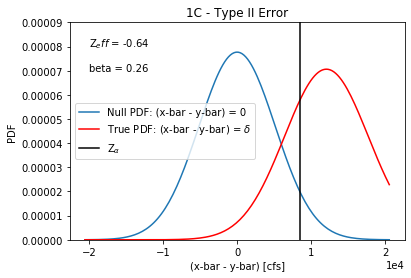

In [5]:
# Make a plot

plt.figure(1)

x = np.linspace(-4, 4, num=160)
x = [i * pooled_sd for i in x]
    
plt.plot(x, st.norm.pdf(x, 0, pooled_sd), label='Null PDF: (x-bar - y-bar) = 0')
plt.plot(x, st.norm.pdf(x, delta_star, sigma_star), color='red', label=r'True PDF: (x-bar - y-bar) = $\delta$')
plt.axvline(z_alpha*pooled_sd, color='black', label=r'Z$_\alpha$')
plt.title('1C - Type II Error')
plt.xlabel('(x-bar - y-bar) [cfs]')
plt.ylabel('PDF')
plt.ylim(0, 9e-5)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.text(-20000, 8e-5, r'Z$_eff$ = ' + str(round(z_eff,2)))
plt.text(-20000, 7e-5, 'beta = ' + str(round(beta,2)))
plt.legend(loc='best')

## Wilcoxan Rank Sum Test
Test the significance of the change in the mean between the two sample periods using the two-sample Wilcoxan Rank Sum test. How different is your conclusion from the one we just did (i.e. compare P for the two tests)? Only consider the case where the null hypothesis is no change.

In [6]:
# Use scipy.stats.wilcoxon()

w, p_w = st.ranksums(early, late)

z_w = st.norm.ppf(1-p_w)

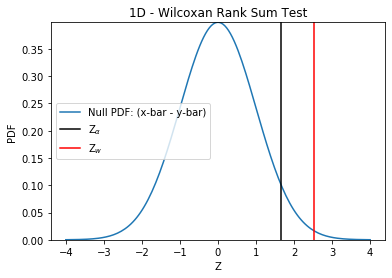

In [7]:
# Plot

plt.figure(1)

mean_w = np.linspace(-4, 4, num=160)

plt.plot(mean_w, st.norm.pdf(mean_w), label='Null PDF: (x-bar - y-bar)')
plt.axvline(z_alpha, color='black', label=r'Z$_\alpha$')
plt.axvline(z_w, color='red', label=r'Z$_w$')
plt.title('1D - Wilcoxan Rank Sum Test')
plt.xlabel('Z')
plt.ylabel('PDF')
plt.ylim(0, max(st.norm.pdf(mean_w)))
plt.legend(loc='best')

## Change in the Standard Deviation
Test for statistical significance of a change in the standard deviation.
Even though it is not strictly true, assume for the moment that the
sample data are derived from a normally distributed population. (We
will follow up on the importance of this assumption in problem 2.) Use a
single sample test (with rejection region based on the Chi Squared
distribution). Assume that the sample standard deviation from the
1929-1974 data is close to the true population standard deviation of the
earlier data set. Test that the more recent sample is different from this.

Use ${t} = \frac{(n-1)s^2}{\sigma^2}$ with n-1 degrees of freedom.

## Monte Carlo Tests
Use random number generation to see if the central value theorem and z-statistics really work.

Look at the following code and modify it for this problem.

1. Start with the empirical CDFs for the two periods that you already made in
your homework.
2. Extrapolate linearly to 0 and 1 (see code provided).
3. Generate 500 samples, each with n = 35, assuming the CDF from the pre
1975.
4. For each of the 500 samples, calculate the sample mean and standard
deviation.
5. Plot histograms and empirical CDFs for the mean and the standard deviation
sets.

(0, 150000)

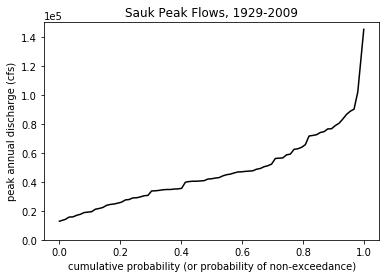

In [8]:
# Start with empirical CDFs

# The function takes an array of data as an argument and returns the data
# as an ordered array and the plotting position associated with each data point.
def quantile_fn(data):

    ordered_data = sorted(data)
    n = len(ordered_data)

    rank = []
    plotting_position = []
    for i in range(n):
        rank.append(i+1)
        # Using the Cunnane plotting position.
        plotting_position.append((rank[i]-.4)/(n+.2))
        
    return ordered_data, plotting_position

data = Skykomish_data['peak value (cfs)']

x_ordered, x_plotting = quantile_fn(data)
x_CDF = [1 - i for i in x_plotting]

x_ordered.reverse()

# Extrapolate linearly to 0 and 1
xsort_first = x_ordered[0] + (x_ordered[0]-x_ordered[1]) * (1-x_CDF[0])/(x_CDF[0]-x_CDF[1])
xsort_last = x_ordered[len(x_ordered)-1] - (x_ordered[len(x_ordered)-1] - x_ordered[len(x_ordered)-2]) * x_CDF[len(x_CDF)-1]/(x_CDF[len(x_CDF)-1]- x_CDF[len(x_CDF)-2])
xsort = [xsort_first]
xsort.extend(x_ordered)
xsort.append(xsort_last)

x_CDF.insert(0, 1)
x_CDF.append(0)
                                    
# Plot
plt.figure()
plt.plot(x_CDF, xsort, color='black')
plt.ylabel('peak annual discharge (cfs)')
plt.xlabel('cumulative probability (or probability of non-exceedance)')
plt.title('Sauk Peak Flows, 1929-2009')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 150000)

In [9]:
# Generate 500 random samples with n=35 assuming CDF from early period

q = np.random.random_sample((500, 35))

# Map to the CDF of our data, this says to look up the x_CDF value and see what actual 
# streamflow value (xsort) corresponds to it
f = interp1d(x_CDF, xsort) # create a function
Q = f(q) # evaluate the function with random values q
   

# It's a good idea to check that you have the right axis here.  
# We want 100 means of 20 numbers each, but if we look at the wrong axis of the matrix, 
# we could get 20 means of 100 numbers each.
Q_mean = np.mean(Q, axis=1)

#here is my printing to check
print(len(Q_mean))

Q_sd = np.std(Q, axis=1)

## We can even plot our randomly generated CDFs if you uncomment this section
#f, ax = plt.subplots(4,5,figsize=(10,7))
#s=0
#for r in range(0,4):
#    for c in range(0,5):
#        ax[r,c].plot(x_CDF, xsort, '-r') # plot the underlying CDF
#        ax[r,c].plot(q[:,s],Q[:,s],'.k') # plot the random points we've mapped to the CDF
#        s+=1
#f.tight_layout() 

500


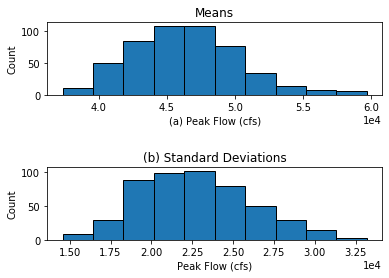

In [10]:
# Plot histograms for mean and sd
nbins = 10

fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1)

axs[0].hist(Q_mean, nbins, ec="black")
axs[0].set_title('Means')
axs[0].set_xlabel('(a) Peak Flow (cfs)')
axs[0].set_ylabel('Count')
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

axs[1].hist(Q_sd, nbins, ec="black")
axs[1].set_title('(b) Standard Deviations')
axs[1].set_xlabel('Peak Flow (cfs)')
axs[1].set_ylabel('Count')
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))

(0, 1)

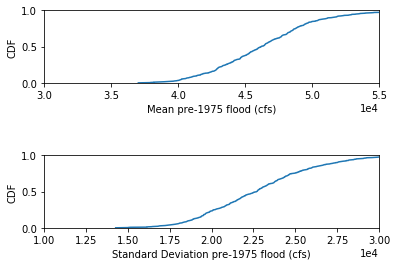

In [11]:
# Plot CDFs for mean and sd

mean_ordered, mean_plotting = quantile_fn(Q_mean)
mean_CDF = [1 - i for i in mean_plotting]

mean_ordered.reverse()

meansort_first = mean_ordered[0] + (mean_ordered[0]-mean_ordered[1]) * (1-mean_CDF[0])/(mean_CDF[0]-mean_CDF[1])
meansort_last = mean_ordered[len(mean_ordered)-1] - (mean_ordered[len(mean_ordered)-1] - mean_ordered[len(mean_ordered)-2]) * mean_CDF[len(mean_CDF)-1]/(mean_CDF[len(mean_CDF)-1]- mean_CDF[len(mean_CDF)-2])
meansort = [meansort_first]
meansort.extend(mean_ordered)
meansort.append(meansort_last)

mean_CDF.insert(0, 1)
mean_CDF.append(0)

sd_ordered, sd_plotting = quantile_fn(Q_sd)
sd_CDF = [1 - j for j in sd_plotting]

sd_ordered.reverse()

sdsort_first = sd_ordered[0] + (sd_ordered[0]-sd_ordered[1]) * (1-sd_CDF[0])/(sd_CDF[0]-sd_CDF[1])
sdsort_last = sd_ordered[len(sd_ordered)-1] - (sd_ordered[len(sd_ordered)-1] - sd_ordered[len(sd_ordered)-2]) * sd_CDF[len(sd_CDF)-1]/(sd_CDF[len(sd_CDF)-1]- sd_CDF[len(sd_CDF)-2])
sdsort = [sdsort_first]
sdsort.extend(sd_ordered)
sdsort.append(sdsort_last)

sd_CDF.insert(0, 1)
sd_CDF.append(0)
                                    
# Plot
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1)

axs[0].plot(meansort, mean_CDF)
axs[0].set_xlabel('Mean pre-1975 flood (cfs)')
axs[0].set_ylabel('CDF')
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_xlim(30000, 55000)
axs[0].set_ylim(0, 1)

axs[1].plot(sdsort, sd_CDF)
axs[1].set_xlabel('Standard Deviation pre-1975 flood (cfs)')
axs[1].set_ylabel('CDF')
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[1].set_xlim(10000, 30000)
axs[1].set_ylim(0,1)